# Demo 1: K-Means and DataStax Analytics
------
<img src="images/socialMedia.jpeg" width="400" height="500">


#### Dataset: https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand

## What are we trying to learn from this dataset? 

# QUESTION: Can K-Means be used to do social media analysis, can we group together different types of media by the reaction they received?


In [99]:
%matplotlib inline
import matplotlib.pyplot as plt

In [100]:
import pandas
import cassandra
import pyspark
import re
import os
import random
from random import randint, randrange
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeans

#### Helper function to have nicer formatting of Spark DataFrames

In [101]:
#Helper for pretty formatting for Spark DataFrames
def showDF(df, limitRows =  5, truncate = True):
    if(truncate):
        pandas.set_option('display.max_colwidth', 50)
    else:
        pandas.set_option('display.max_colwidth', -1)
    pandas.set_option('display.max_rows', limitRows)
    display(df.limit(limitRows).toPandas())
    pandas.reset_option('display.max_rows')

# DataStax Enterprise Analytics
<img src="images/dselogo.png" width="400" height="200">

## Creating Tables and Loading Tables

### Connect to DSE Analytics Cluster

In [102]:
from cassandra.cluster import Cluster

cluster = Cluster(['127.0.01'])
session = cluster.connect()

### Create Demo Keyspace 

In [103]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS accelerate 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

### Set keyspace 

In [105]:
session.set_keyspace('accelerate')

### Create table called `socialMedia`. Our PRIMARY will be a unique key (status_id) we generate for each row. 

In [106]:
query = "CREATE TABLE IF NOT EXISTS socialMedia \
                                   (status_id int, social_type text, num_reactions int,\
                                   num_comments int, num_shares int, num_likes int, num_loves int,\
                                   num_wows int, num_hahas int, num_sads int, num_angrys int, \
                                   PRIMARY KEY (status_id))"
session.execute(query)

### What do these of these 11 columns represent: 

* **Status_id**: Unique key created for each row

* **Num Reactions**: 

* **Num Comments**:

* **Num Shares**:

* **Num Likes**:

* **Num Loves**:

* **Num Wows**:

* **Num Hahas**:

* **Num Sads**:

* **Num Angrys**:

* **Social Type**: Picture or Video


### Load Social Media Dataset
<img src="images/getTheLikes.png" width="300" height="300">

### Load Car dataset from CSV file (socialMedia.csv)

#### Insert all the Car Data into the Apache Cassandra table `socialmedia`

In [107]:
fileName = 'data/socialMedia.csv'
input_file = open(fileName, 'r')
i = 1
for line in input_file:
    statusId = i
    row = line.split(',')
    
    if row[0] != "photo" and row[0] != "video":
        continue

    query = "INSERT INTO socialmedia (status_id, social_type, num_reactions, num_comments, num_shares,\
                               num_likes, num_loves, num_wows, num_hahas, num_sads, num_angrys)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (statusId, row[0], int(row[1]), int(row[2]), int(row[3]), int(row[4]), int(row[5]), int(row[6]), int(row[7]), int(row[8]), int(row[9])))
    i = i + 1
    

## Machine Learning with DSE Analytics and Apache Spark
<img src="images/sparklogo.png" width="150" height="200">

#### Create a spark session that is connected to DSE. From there load each table into a Spark Dataframe and take a count of the number of rows in each.

In [109]:
spark = SparkSession.builder.appName('demo').master("local").getOrCreate()


socialDF = spark.read.format("org.apache.spark.sql.cassandra").options(table="socialmedia", keyspace="accelerate").load()

print ("Table Row Count: ")
print (socialDF.count())

Table Row Count: 
6621


In [110]:
showDF(socialDF)

,status_id,num_angrys,num_comments,num_hahas,num_likes,num_loves,num_reactions,num_sads,num_shares,num_wows,social_type
0,5691,0,1,0,13,0,13,0,1,0,photo
1,728,0,1,0,136,1,138,0,0,1,photo
2,6490,0,3529,8,217,17,247,4,163,1,video
3,208,0,6,0,42,1,43,0,0,0,photo
4,1939,0,5,0,24,0,24,0,0,0,photo


#### When working with `STRING` data types you need to turn those `STRING` types into `FLOAT` types. Creating labels that K-MEANS and Apahce SPARK can understand.

In [111]:
labelIndexer = StringIndexer(inputCol="social_type", outputCol="label", handleInvalid='keep')
training = labelIndexer.fit(socialDF).transform(socailDF)

showDF(training)


,status_id,num_angrys,num_comments,num_hahas,num_likes,num_loves,num_reactions,num_sads,num_shares,num_wows,social_type,label
0,5691,0,1,0,13,0,13,0,1,0,photo,0.0
1,728,0,1,0,136,1,138,0,0,1,photo,0.0
2,6490,0,3529,8,217,17,247,4,163,1,video,1.0
3,208,0,6,0,42,1,43,0,0,0,photo,0.0
4,1939,0,5,0,24,0,24,0,0,0,photo,0.0


In [112]:
showDF(training.select("social_type","label"))

,social_type,label
0,video,1.0
1,photo,0.0
2,photo,0.0
3,video,1.0
4,photo,0.0


In [113]:
training.groupBy('social_type').count().show()

+-----------+-----+
|social_type|count|
+-----------+-----+
|      video| 2333|
|      photo| 4288|
+-----------+-----+



## Let's visualize this data with a scatter plot 
### The x axis will be number of likes 
### The y axis will be number of comments
### The color of the dot will be assigned based on its "cluster" Photo or Video

Note: These attributes are what might be a strong attributes to finding clusters (Photo - Video)
Note 1: Must move to a Pandas dataframe to do this visualization (be aware! This can't always be done as is, depends on your data size)

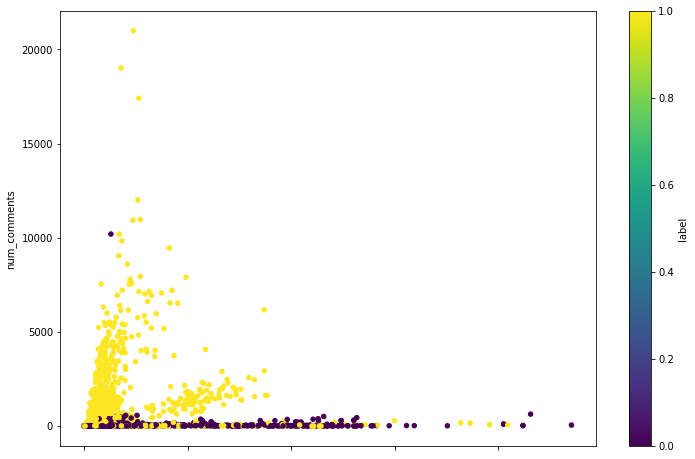

In [88]:
carPanda = training.toPandas()
carPanda.plot.scatter(x = 'num_likes', y = 'num_comments', c= 'label', figsize=(12,8), colormap='viridis')

### Two clusters here Yellow = Video  and Purple = Pictures

From what we can see from these two attributes Videos get less likes but more comments. Pictures get less comments but more likes. 

## Let's see if Kmeans can give us the same clustering

## K-means clustering is a simple unsupervised learning algorithm that is used to solve clustering problems. Kmeans is very simple, but very powerful even on large datasets. It requires that all the input columns be vectorized. 

https://spark.apache.org/docs/latest/ml-features.html#vectorassembler

In [122]:
assembler = VectorAssembler(
    inputCols=[ 'num_likes', 'num_comments'],
    outputCol='features')

trainingData = assembler.transform(training)

### We need to set the K for KMeans which we will set at 2. One of the downsides of unsupervised learning is that we normally will not have clusteres predefinded (like we do in this case). Kmeans will happily split the data into as many clusters as you set. 

#### First we will generate the model and then make predictions based on that model 

In [123]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(trainingData)

# Make predictions
predictions = model.transform(trainingData)

showDF(predictions)

,status_id,num_angrys,num_comments,num_hahas,num_likes,num_loves,num_reactions,num_sads,num_shares,num_wows,social_type,label,features,prediction
0,5691,0,1,0,13,0,13,0,1,0,photo,0.0,"[13.0, 1.0]",0
1,728,0,1,0,136,1,138,0,0,1,photo,0.0,"[136.0, 1.0]",0
2,6490,0,3529,8,217,17,247,4,163,1,video,1.0,"[217.0, 3529.0]",1
3,208,0,6,0,42,1,43,0,0,0,photo,0.0,"[42.0, 6.0]",0
4,1939,0,5,0,24,0,24,0,0,0,photo,0.0,"[24.0, 5.0]",0


## In this case because we are actually preforming surpervised learnings (since we do have the cluster labels) we can do some comparisions to see if our predictions are correct. 

## In this case I am just taking a look at the counts for each group. 

In [125]:
predictions.groupBy('prediction').count().show()
training.groupBy('social_type').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  137|
|         0| 6484|
+----------+-----+

+-----------+-----+
|social_type|count|
+-----------+-----+
|      video| 2333|
|      photo| 4288|
+-----------+-----+



## Let's create another scatter plot to see if this lines up with our orignal scatter plot. 

## Everything is the same except now our dots will represent the color of the prediction (instead of the orginal cluster)

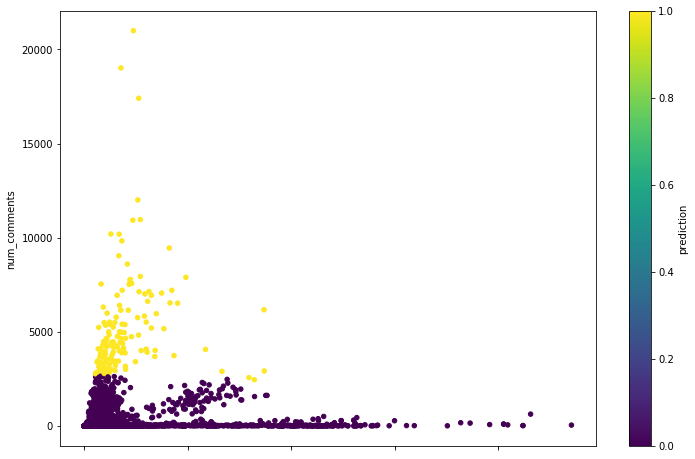

In [121]:
car_df = predictions.toPandas()

car_df.plot.scatter(x = 'num_likes', y = 'num_comments', c= 'prediction', figsize=(12,8), colormap='viridis')

### Videos are represented in yellow and pictures are represnted in purple.

## KMeans struggles when you add many variables, so adding more variables is unlikely to help. 

# Remember Data Science and analytics is an iterative process! It's a science! Hypothesis, test, analysis, and loop again! 

In [71]:
session.execute("""drop table socialmedia""")